# Operator overloading in python

In [13]:
class Planet:
    def __init__(self, moons):
        self.moons = moons
    
    def __add__(self, newplanet):
        newmoons = self.moons + newplanet.moons
        return Planet(moons=newmoons)

In [14]:
p1 = Planet(['Gany', 'Titan'])
p2 = Planet(['phobo', 'dimo'])

In [15]:
p3 = p1+p2

In [16]:
p3.moons

['Gany', 'Titan', 'phobo', 'dimo']

# GPcore Tests

todo:
- movie save
- data save - python full wrapper
- growth rates
- ring potential - edge states (set V?)
- bdg
- timedependent v
- 

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
try:
    restartkernel()
except:
    pass

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.append(os.path.abspath('..'))

from condensate.core import gpcore
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
import time
import h5py
import pandas as pd
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:

omega = 10.

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 400 * 1e-6

In [3]:
DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,1000,40, True, 5e7)

xrelax = x.copy()

# mouse tests

In [6]:

omega = 10.

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 400 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)
gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.Evolve(x,1000,40, True, 5e7)


gpcore.Setup(DIM, fov, g, 1e-4,  False, 0.01)
gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.SetupSpoon(1e5, 20e-6)
# gpcore.SetupLeapMotion(-250,500,1,1, False)
# gpcore.RotatingFrame(Omega)

gpcore.Evolve(x,0,40, True, 5e7)

# Geometric squeezing

In [3]:

omega = 2*np.pi*10

hbar = 1.05e-34
omegaz = np.sqrt(8) * omega
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 1e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
lb = np.sqrt(hbar / (2*mass *omega))

fov = 300 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
noise = (0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        noise[i,j]= np.exp(0.2 * 1.j * 2*np.pi * (0.5-np.random.rand()))
        

gpcore.Setup(DIM, fov, g, 1e-5,  True, 0)
gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.Evolve(x,10000,100, True, 3e8)
xrelax = x.copy()

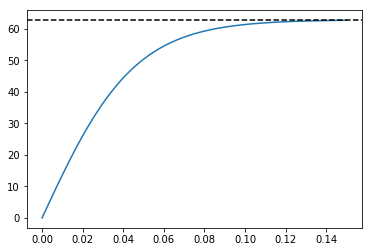

In [118]:
whirrMax = omega

steps = 30000
times = np.arange(steps)
whirrtime = 30000

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]

# Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]

plt.plot(5e-6*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')

In [119]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 1e-5, False, 0.00)

gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,150e-6)

gpcore.Evolve(x, steps, 50, True, 1e8)

xwide = x.copy()

In [125]:
def geometric_squeezing(stripPsi, steps=60000, show=True, frames=300, datafile='data/geometricsqueezing.hdf5'):
    steps = frames*(steps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    dt = 1e-5
    x = stripPsi.copy()
    vmax = np.max(np.abs(x))**2
    out = []
    density = np.fliplr(np.abs(x.copy())**2)
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        vmax = np.max(np.abs(x))**2
        gpcore.Setup(DIM, fov, g, dt, False, 0.00)
        gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
        gpcore.RotatingFrame(Omega)
        gpcore.AbsorbingBoundaryConditions(1,150e-6)
        gpcore.Evolve(x, runtime, 50, show, vmax)
        
        density = np.fliplr(np.abs(x.copy())**2)
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"geosqueeze"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

In [126]:
geometric_squeezing(xwide)

## process data

In [4]:
# Set some processing parameters
viewx = 200
viewy = 350
dx = fov/DIM
x  = dx * (np.arange(viewx) - viewx//2)
y  = dx * (np.arange(viewy) - viewy//2)
dt = 1e-5
times = np.arange(51)*dt*5e3


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped


def process_r1d(dset):
    """ Process a dataset corresponding to a single squeeze time """
    clouds = np.array([rotate_crop(a, viewx, viewy, 42) for a in dset[()]])
    times = np.array(dset.attrs['time'])
    xprofile  =  np.sum(rotate_crop(clouds[0],viewy=150), axis=0)
    xprofilemax = np.max(xprofile)
    gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
    newresults = pd.DataFrame([[clouds, times, xprofile, gaussfit]],
                              columns=columns)
    return newresults




In [5]:
columns = ['cloud', 'time', 'xprofile', 'gaussfit']
gs = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = rotate_crop(dset[i], viewx, viewy, 42)
            xprofile  =  np.sum(rotate_crop(cloud, viewy=150), axis=0)
            xprofilemax = np.max(xprofile)
            gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
            newresults = pd.DataFrame([[cloud, alltimes[i], xprofile, gaussfit]], columns=columns)
            gs = gs.append(newresults)
            
        
        
    

In [6]:
gs.head()

,cloud,time,xprofile,gaussfit
0,"[[4.905149340493483e-42, -4.37944821057761e-42...",0.000,"[-1.4913597749154622e-41, 8.833926220549507e-4...","[-4.720021113437443e-07, 5678759536.883862, 7...."
0,"[[-4.00318299520465e-43, 4.981436476175978e-43...",0.002,"[6.141879091559284e-42, -2.408797778274608e-41...","[-5.260058482318129e-07, 5671764635.024336, 7...."
0,"[[-1.6146045602392343e-43, 1.2750699797526093e...",0.004,"[-7.080467364250093e-43, 7.473998702900885e-42...","[-5.534763883937312e-07, 5619518364.865945, 7...."
0,"[[-4.654626000069831e-44, 4.703194085622458e-4...",0.006,"[3.6919637349482274e-43, 1.3493878918657208e-4...","[-5.466852539888375e-07, 5513902790.05629, 7.2..."
0,"[[5.217617878736581e-43, -3.881018652670207e-4...",0.008,"[5.833455012813719e-42, -2.2301180013776574e-4...","[-5.057335988334069e-07, 5358750845.014216, 7...."


In [13]:
widths = np.array([abs(r[4][2]) for r in gs.itertuples()])

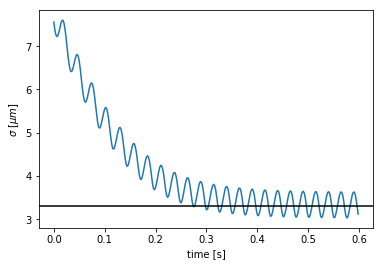

In [495]:
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
plt.savefig('figures/rotini1d/widths.png')


# 1D rotini

In [604]:

omega = 2*np.pi*10

hbar = 1.05e-34
omegaz = np.sqrt(8) * omega
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 1e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
lb = np.sqrt(hbar / (2*mass *omega))

fov = 300 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
noise = (0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        noise[i,j]= np.exp(0.2 * 1.j * 2*np.pi * (0.5-np.random.rand()))
        

gpcore.Setup(DIM, fov, g, 1e-5,  True, 0)
gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.Evolve(x,10000,100, True, 3e8)
xrelax = x.copy()

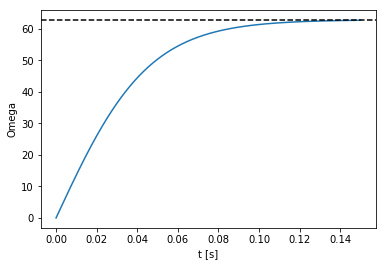

In [606]:
whirrMax = omega

steps = 30000
times = np.arange(steps)
whirrtime = 30000

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]

# Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]

plt.plot(5e-6*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.ylabel('Omega')
plt.xlabel('t [s]')
plt.savefig('figures/rotini1d/rampup.png')

In [173]:
Omega[-1] - whirrMax

-0.10809306368710736

In [607]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 1e-5, False, 0.00)

gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,150e-6)

gpcore.Evolve(x, steps, 50, True, 1e8)

xwide = x.copy()

In [608]:
xstart = xwide.copy()
gpcore.Setup(DIM, fov, g, 1e-5, False, 0.00)
steps = 60000
Omega = 1.0*whirrMax* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,150e-6)

gpcore.Evolve(xstart, steps, 50, True, 4e6)

xthin = xstart.copy()

In [609]:
noise = (0.j)*np.zeros((DIM,DIM))
for i in range(DIM):
    for j in range(DIM):
        noise[i,j]= np.exp(0.1 * 1.j * 2*np.pi * (0.5-np.random.rand()))

In [687]:
# xstart = xwide.copy() * noise
# xstart = xthin.copy()* noise
gpcore.Setup(DIM, fov, g, 1e-5, False, 0.00)
steps = 1000000
Omega = whirrMax* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
gpcore.RotatingFrame(Omega)
# gpcore.AbsorbingBoundaryConditions(1,150e-6)

gpcore.Evolve(xstart, steps, 500, True, 2e4)

In [654]:
2*np.sqrt(2*hbar*omega/mass)/omega

1.8756763846479772e-05

In [652]:
np.sqrt(2*g*1e9/mass)/omega

0.00016144274063732553

In [651]:
hbar*omega

6.597344572538566e-33

# 1D growths - vary waittime

In [5]:
def compute_rotini(stripPsi, stripsteps, rotinisteps=250000, show=True, frames=50, datafile='data/rotinigrowth.hdf5'):
    steps = frames*(rotinisteps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    dt = 1e-5
    x = stripPsi.copy() * noise
    vmax = np.max(np.abs(x))**2
    out = []
    density = np.fliplr(np.abs(x.copy())**2)
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        gpcore.Setup(DIM, fov, g, dt, False, 0.00)
        gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
        gpcore.RotatingFrame(Omega)
        gpcore.Evolve(x, runtime , 50, show, vmax)
        
        density = np.fliplr(np.abs(x.copy())**2)
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"rotini1D_{stripsteps}"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['stripsteps'] = stripsteps
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

In [6]:
stripstepslist = list(np.arange(0,60000,2000)) 

In [12]:
dt = 1e-5
xstart = xwide.copy()
vmax = np.max(np.abs(xstart))**2
compute_rotini(xstart, 0)

runtime = 4000
Omega = omega * np.ones(runtime)

for stripsteps in tqdm(stripstepslist[12:]):
    vmax = np.max(np.abs(xstart))**2
    gpcore.Setup(DIM, fov, g, dt, False, 0.00)
    gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
    gpcore.RotatingFrame(Omega)
    gpcore.AbsorbingBoundaryConditions(1,150e-6)
    gpcore.Evolve(xstart, runtime, 50, True, vmax)
    compute_rotini(xstart, stripsteps)

## process data

In [15]:
# recall experimental parameters
omega = 2*np.pi*10

hbar = 1.05e-34
omegaz = np.sqrt(8) * omega
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 1e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
lb = np.sqrt(hbar / (2*mass *omega))

fov = 300 * 1e-6
DIM = 512

In [141]:
# Set some processing parameters
viewx = 200
viewy = 350
dx = fov/DIM
x  = dx * (np.arange(viewx) - viewx//2)
y  = dx * (np.arange(viewy) - viewy//2)
dt = 1e-5
times = np.arange(51)*dt*5e3
columns = ['clouds', 'times', 'squeezeTime', 'yprofiles', 'xprofile', 'gaussfit', 'variance']

def twoline(t, start, tswitch, end):
    return (start + t*(end-start)/tswitch) if t<tswitch else end
twoline = np.vectorize(twoline)

def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped


def process_r1d(dset):
    """ Process a dataset corresponding to a single squeeze time """
    clouds = np.array([rotate_crop(a, viewx, viewy, 42) for a in dset[()]])
    times = np.array(dset.attrs['time'])
    squeezeTime = dset.attrs['stripsteps'] * dt
    yprofiles = np.array([np.sum(c, axis=1) for c in clouds])
    xprofile  =  np.sum(rotate_crop(clouds[0],viewy=150), axis=0)
    xprofilemax = np.max(xprofile)
    gaussfit,_ = curve_fit(gauss, 1e6*x, xprofile/xprofilemax, [0, 1, 6])
    variance = np.array([np.std(p) for p in yprofiles])
    newresults = pd.DataFrame([[clouds, times, squeezeTime, yprofiles, xprofile, gaussfit, variance]],
                              columns=columns)
    return newresults

def animate_images(images, mode='show', filename='figures/animation.mp4'):
    """ Animate a sequence of images """
    fig = plt.figure(figsize=(4,4))
    plt.axis("off")
    plt.tight_layout()
    ims = [[plt.imshow(c, animated=True)] for c in images]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    plt.close()
    if mode=='show':
        return HTML(ani.to_jshtml())
    else:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        ani.save(filename, writer=writer)
        print('file saved to ' + filename)

def plot_stack(images, frames=8, title=None):
    skip = len(images)//frames
    fig = plt.figure(figsize=(8,4))
    stack = np.hstack(images[::skip])
    plt.axis("off")
    plt.title(title, fontsize=19)
    plt.tight_layout()
    plt.imshow(stack)
    plt.show()
    return fig



In [17]:
results = pd.DataFrame(columns=columns)

with h5py.File('data/rotinigrowth.hdf5', 'r') as f:
    for name in tqdm(f):
        results = results.append(process_r1d(f[name]))
    
results = results.sort_values(by='squeezeTime', ignore_index=True)

In [18]:
results = results[::2].reset_index()

In [144]:
for i, row in results.iterrows():
    if i in [0, 2, 5, 8,9,10,13]:
        animate_images(row.clouds, mode='save', filename=f'figures/rotini1d/animations/rotini1d_{i}.mp4')

file saved to figures/rotini1d/animations/rotini1d_0.mp4
file saved to figures/rotini1d/animations/rotini1d_2.mp4
file saved to figures/rotini1d/animations/rotini1d_5.mp4
file saved to figures/rotini1d/animations/rotini1d_8.mp4
file saved to figures/rotini1d/animations/rotini1d_9.mp4
file saved to figures/rotini1d/animations/rotini1d_10.mp4
file saved to figures/rotini1d/animations/rotini1d_13.mp4


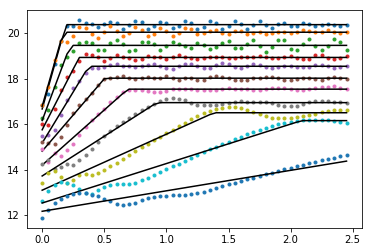

In [514]:
growthrates = []
errs= []
for i, row in tqdm(results.iterrows()):
    if i<11:
        f,e = curve_fit(twoline, row.times, np.log(row.variance[1:]), [14.5,1,17])
        plt.plot(row.times, np.log(row.variance[1:]),'.')
        plt.plot(row.times,twoline(row.times,*f),'k-')
        growthrate = f[1]
        e = np.sqrt(np.diag(e))
        err = e[1]
    else:
        growthrate = np.nan
        err = np.nan
    growthrates.append(growthrate)
    errs.append(err)

plt.savefig('figures/rotini1d/growths_all.png')

In [482]:
for i, row in tqdm(results.iterrows()):
    row = results.iloc[i]
    fig2 = plt.subplots(ncols=2,nrows=2, figsize=(14,6))

    plt.subplot(221)
    plt.plot(1e6*x,row.xprofile   ,'r',lw=2)
    plt.plot(1e6*x, row.xprofile.max()* gauss(1e6*x, *row.gaussfit),'k-', alpha=0.5)
    plt.xlim([-35,35])
    plt.title('initial xprofile and residuals')
    plt.ylabel(r'x[ $\mu m$]')

    ax2 = plt.gca().twinx()
    plt.plot(1e6*x, -(row.xprofile - row.xprofile.max()* gauss(1e6*x, *row.gaussfit)),'--',c='grey',alpha=0.3)
    plt.ylim([-row.xprofile.max()*0.1,row.xprofile.max()*0.1])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,3)) 

    plt.subplot(223)
    plt.plot(1e6*y, row.yprofiles[-1] ,'r')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,3)) 
    plt.title('final yprofile')
    plt.ylabel(r'y [$\mu m$]')

    plt.subplot(222)
    stack = np.hstack(row.clouds[::8])
    plt.axis("off")
    plt.imshow(stack, cmap='inferno')
    t = np.round(row.squeezeTime, decimals=3)
    plt.title(f"squeezing time = {t} s")

    plt.subplot(224)
    if i<11:
        f,_ = curve_fit(twoline, row.times, np.log(row.variance[1:]), [14.5,0.6,17])
        plt.plot(row.times,twoline(row.times,*f),'k-')
    plt.plot(row.times, np.log(row.variance[1:]),'c.')
    plt.title('growth of log(variance) of yprofiles')
    plt.ylabel('t [s]')

    plt.tight_layout()
    plt.savefig(f'figures/rotini1d/rotini1d_{i}.png')
    plt.close()
        

In [515]:
allvars = []
allsigmas = []
maxes = []
for i,r in results.iterrows():
    allvars.append(r.variance)
    maxes.append(r.xprofile.max())
    allsigmas.append(abs(r.gaussfit[2]))
    

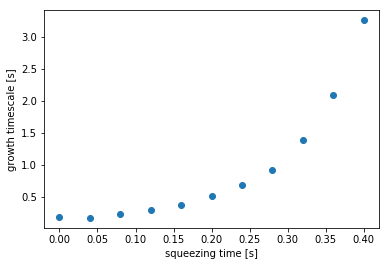

In [518]:
plt.plot(results.squeezeTime,np.array(growthrates),'o')
plt.xlabel('squeezing time [s]')
plt.ylabel('growth timescale [s]')
plt.savefig('figures/rotini1d/growth_squeeze.png')

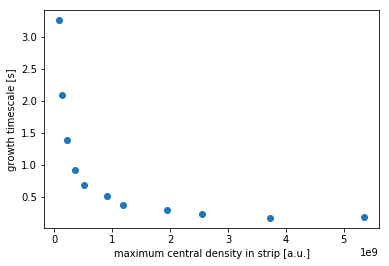

In [504]:
plt.plot(maxes,growthrates,'o')
plt.ylabel('growth timescale [s]')
plt.xlabel('maximum central density in strip [a.u.]')
plt.savefig('figures/rotini1d/growth_nmax.png')

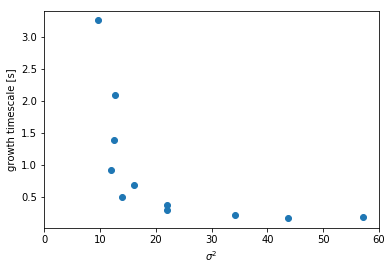

In [490]:
plt.plot([s**2 for s in allsigmas],growthrates,'o')
plt.xlim([0,60])
plt.xlabel(r'$\sigma^2$')
plt.ylabel('growth timescale [s]')
plt.savefig('figures/rotini1d/growth_nlll.png')

In [497]:
f,_ = curve_fit(satexp, np.arange(len(results)), allsigmas,[10,3])
newsigmas = satexp(np.arange(len(results)), *f)

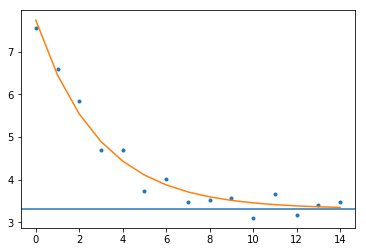

In [498]:
plt.plot(allsigmas,'.')
plt.plot(newsigmas)
plt.axhline(3.31)

In [499]:
allgrowths = np.log(np.vstack(allvars)).T

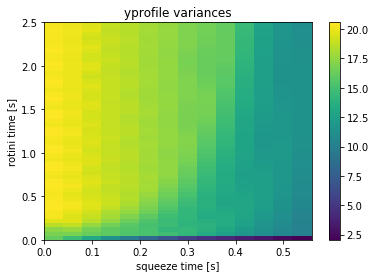

In [507]:
plt.pcolormesh(results.squeezeTime, times, allgrowths)
plt.colorbar()
plt.ylabel('rotini time [s]')
plt.xlabel('squeeze time [s]')
plt.title('yprofile variances')
plt.savefig('figures/rotini1d/growths_all_2dplot.png')


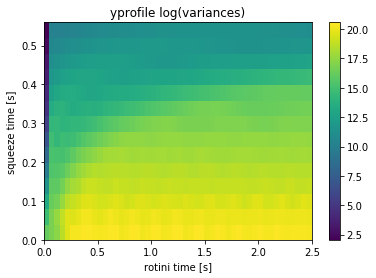

In [510]:
plt.pcolormesh(times,results.squeezeTime,  allgrowths.T)
plt.colorbar()
plt.xlabel('rotini time [s]')
plt.ylabel('squeeze time [s]')
plt.title('yprofile log(variances)')
plt.savefig('figures/rotini1d/growths_all_2dplot.png')

Text(0.5, 1.0, 'yprofile variances')

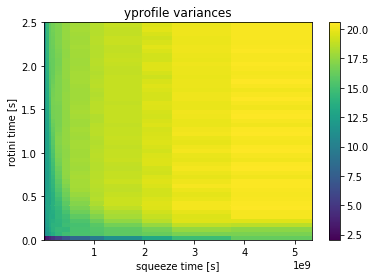

In [505]:
plt.pcolormesh(maxes, times, allgrowths)
plt.colorbar()
plt.ylabel('rotini time [s]')
plt.xlabel('squeeze time [s]')
plt.title('yprofile variances')
# plt.savefig('figures/rotini1d/growths_all_2dplot.png')


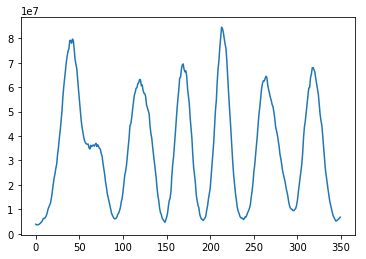

In [522]:
row = results.iloc[7]
plt.plot(row.yprofiles[-1])

In [552]:
dk = 1/(1e6*dx*viewy)
k = dk*np.arange(viewy)

In [598]:
1/(0.035)

28.57142857142857

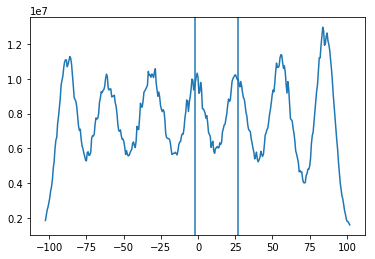

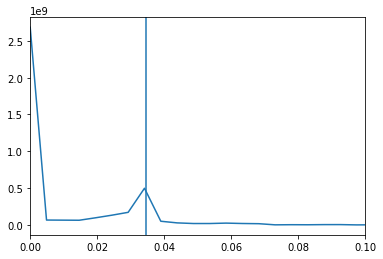

In [603]:
row = results.iloc[10]
plt.plot(1e6*y,row.yprofiles[-1])
plt.axvline(-2)
plt.axvline(27)
plt.show()
plt.plot(k,np.abs(np.fft.fft(row.yprofiles[-1])))
plt.xlim([0,.1])
plt.axvline(1/29)

In [583]:
allffts = []
for i,row in results.iterrows():
    prof = row.yprofiles[-2]
    prof = (prof-prof.mean())/prof.max()
    fft = np.abs(np.fft.fft(prof))**2
    allffts.append(fft)

In [684]:
pred = 5*1e-6/(np.sqrt(2*g*np.array(maxes)/mass)/omega)

In [685]:
pred

array([0.01339465, 0.016061  , 0.01937239, 0.02219861, 0.02841888,
       0.0325199 , 0.04320237, 0.05153766, 0.06673973, 0.0862098 ,
       0.1031321 , 0.14405508, 0.17173535, 0.22909567, 0.29746221])

Text(0, 0.5, 'squeeze time [s]')

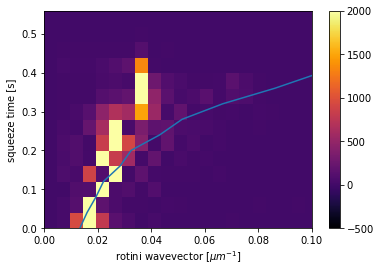

In [686]:
plt.pcolormesh(k,results.squeezeTime,allffts, vmax=2e3, vmin=-0.5e3, cmap='inferno')
plt.plot(pred, results.squeezeTime)
plt.colorbar()
plt.xlim([0,.1])
plt.axvline(1e-6/lb,c='w',ls='--')
plt.xlabel(r'rotini wavevector [$\mu m ^{-1}$]')
plt.ylabel('squeeze time [s]')
# plt.savefig('figures/rotini1d/rotinilengthscale.png')

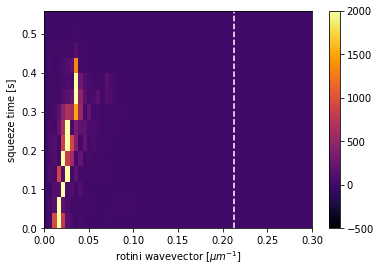

In [670]:
plt.pcolormesh(k,results.squeezeTime,allffts, vmax=2e3, vmin=-0.5e3, cmap='inferno')
plt.colorbar()
plt.xlim([0,.3])
plt.axvline(1e-6/lb,c='w',ls='--')
plt.xlabel(r'rotini wavevector [$\mu m ^{-1}$]')
plt.ylabel('squeeze time [s]')
# plt.savefig('figures/rotini1d/rotinilengthscale.png')

(0, 0.1)

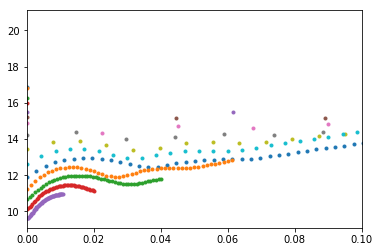

In [641]:

for i, row in tqdm(results.iterrows()):
#     plt.plot(row.times* (row.xprofile.max()/1e9)**1.2 , np.log(row.variance[1:]),'.')
    plt.plot(row.times* (row.xprofile.max()/1e9)**1.2 , np.log(row.variance[1:]),'.')
    
plt.xlim([0,.1])


# 1D growths - vary g


In [130]:
stepslist = np.arange(0,20000,1000)

In [519]:
glist = 9.275086005434142e-40 * np.array([0,0.0001, 0.001,0.01,0.02,0.03,0.04,0.05,0.1,1])

columns = ['g', 'steps', 'Psi']
results1d = pd.DataFrame(columns=columns)


for g in tqdm(glist):
    
    DIM = 512
    x = (1+0.j)*np.zeros((DIM,DIM))
    V = np.zeros((DIM,DIM))
    width = 10
    for i in range(DIM):
        for j in range(DIM):
            x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j


    gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

    gpcore.SetHarmonicPotential(omega,0.0) 

    gpcore.Evolve(x,1000,40, True, 3e8)
    
    whirrMax = omega

#     if g<0.03:
#         steps = 30000
#     else:
    steps = 30000
    whirrtime = 20000
    times = np.arange(steps)

    Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]
    gpcore.Setup(DIM, fov, g, 2e-4, False, 0.000)
    gpcore.SetHarmonicPotential(omega,0.18) #omega, epsilon
    gpcore.RotatingFrame(Omega)
    gpcore.AbsorbingBoundaryConditions(1,600e-6)
    gpcore.Evolve(x, steps, 500, True, 1e8)
    
    for steps in tqdm(stepslist, leave=False):
        gpcore.Setup(DIM, fov, g, 1e-3, False, 0.00)
        Omega = whirrMax* np.ones(1000)
        gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
        gpcore.RotatingFrame(Omega)
        gpcore.AbsorbingBoundaryConditions(1,600e-6)
        gpcore.Evolve(x, 1000, 50, True, 7e6)
        
        Psi = x.copy()
        newresults = pd.DataFrame([[g,steps,Psi]],columns=columns)
        results1d = results1d.append(newresults,  ignore_index=True)

# 2D Rotini

In [9]:

omega = 2*np.pi*2

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 2e4
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 500 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

gpcore.Setup(DIM, fov, g, 2e-3,  True, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,1000,40, True, 3e8)
xrelax=x.copy()

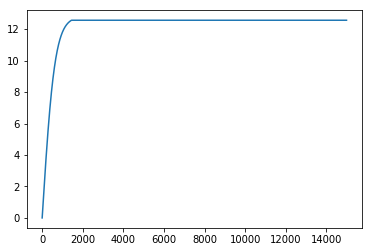

In [11]:
whirrMax = omega
# whirrMax = np.sqrt(1-0.16)*omega

steps = 15000
times = np.arange(steps)
whirrtime = 1500

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, whirrMax * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]
# Omega = [np.max([whirrMax, 2*omega - (omega * 1.02 * np.tanh(2.4 * t / whirrtime)) ]) for t in times]

plt.plot(times, Omega)

In [14]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 1e-3, False, 0.001)

gpcore.SetHarmonicPotential(omega,0.2) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,200e-6)

gpcore.Evolve(x, steps, 50, True, 0.6e8)

In [60]:
xstart = x.copy()
gpcore.Setup(DIM, fov, g, 1e-3, False, 0.005)

gpcore.SetHarmonicPotential(omega,0.16) #omega, epsilon
gpcore.RotatingFrame([whirrMax])
gpcore.AbsorbingBoundaryConditions(0,1000e-6)
gpcore.SetupSpoon(100, 1000e-6)

gpcore.Evolve(xstart, 0, 50, True, 0.6e8)

In [758]:
# # back to circ
# steps = 3500
# Omega = whirrMax* np.ones(steps)
# gpcore.Setup(DIM, fov, g, 1e-3, False, 0.0001)

# gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
# gpcore.RotatingFrame(Omega)

# gpcore.Evolve(x, steps, 50, True, 1e8)

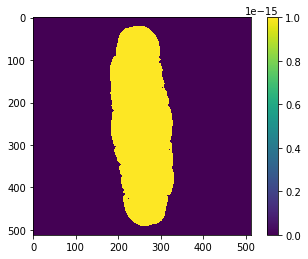

In [25]:
# plt.figure(figsize=(18,18))
plt.imshow(np.abs(x)**2* (np.abs(x)**2 >1), vmax=1e-15)
plt.colorbar()

plt.show()

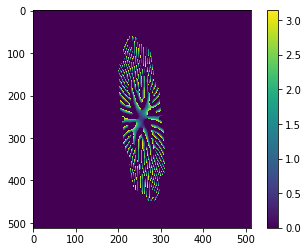

In [10]:
# plt.figure(figsize=(18,18))
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e6), vmin=0)
plt.colorbar()

plt.show()

# epsilon-omega

In [8]:
view = 300

def compute_rotini(Omega=0.9, epsilon=0.16, steps=14000, show=True, frames=50, datafile='data/epsilonomega.hdf5', savetype='density'):
    steps = frames*(steps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    whirrtime = 1500
    whirrMax = Omega*omega
    Omegalist = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]
    x = xrelax.copy()
    dt = 1e-3
    out = []
    
    for i in tqdm(range(frames), leave=False):
        gpcore.Setup(DIM, fov, g, dt, False, 0.007)
        gpcore.SetHarmonicPotential(omega,epsilon) #omega, epsilon
        gpcore.RotatingFrame(Omegalist[i*runtime : (i+1)*runtime])
        gpcore.AbsorbingBoundaryConditions(1,500e-6)
        gpcore.Evolve(x, runtime , 50, show, 0.3e8)
        if savetype=='density':
            density = np.fliplr(np.abs(x.copy())**2)
            density *= density>1
            out.append(density[256-view//2 : 256+ view//2, 256-view//2 : 256+ view//2])
        else:
            out.append(x.copy())
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"rotini2D_{Omega}_{epsilon}"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['Omega'] = Omega
        dset.attrs['epsilon'] = epsilon
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        
def plot_epsilon_omega(full, show=True, save=False, frame=0):
    plt.figure(figsize=(18,18))
    plt.imshow(full, cmap='inferno',origin='lower', vmax=7e7)
    for i in range(len(Omegalist)):
        plt.axvline(i*view, color='w', lw=0.5)
    for i in range(len(epsilonlist)):
        plt.axhline(i*view, color='w', lw=0.5)
    plt.xticks(np.arange(view//2, len(Omegalist)*view, view), Omegalist) 
    plt.yticks(np.arange(view//2, len(epsilonlist)*view, view), epsilonlist) 
    plt.gca().tick_params(labelsize=19)
    plt.xlabel('$\Omega/\omega$', size=23)
    plt.ylabel('$\epsilon$', size=23)
    plt.tight_layout()
    if save: plt.savefig(f"figures/epsilonomegamovie/epomega_{frame}.png", dpi=210)
    if show: plt.show()
    plt.close()

In [18]:
compute_rotini(frames=100, savetype='other')

In [7]:
Omegalist = [0.7,0.75,0.8, 0.85, 0.86,0.87, 0.88, 0.89, .9,0.91, .92, .94, .96, 1]
epsilonlist = [0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24]

In [8]:
# Run the entire simulation

for Omega in tqdm(Omegalist):
    for epsilon in tqdm(epsilonlist, leave=False):
        compute_rotini(Omega, epsilon)

In [ ]:
# process the data
for frame in tqdm(range(50)):
    columns = ['Omega', 'epsilon', 'density']
    results = pd.DataFrame(columns=columns)

    with h5py.File('data/epsilonomega.hdf5', 'r') as f:
        for name in f:
            dataset = f[name]
            density = dataset[frame]
            Omega = dataset.attrs["Omega"]
            epsilon = dataset.attrs["epsilon"]
            newresults = pd.DataFrame([[Omega,epsilon,density]],columns=columns)
            results = results.append(newresults,  ignore_index=True)

    results = results.sort_values(by=["Omega", "epsilon"], ignore_index=True)

    allimages = []
    for i,r in results.iterrows():
        allimages.append(r.density)

    reshaped = np.reshape(allimages, [len(Omegalist), len(epsilonlist), view, view])
    full = np.hstack([np.vstack(reshaped[i,:,:,:]) for i in range(len(Omegalist))])

    plot_epsilon_omega(full, show=False, save=True, frame=frame)

In [9]:
frame = 59
with h5py.File('data/movie_1.hdf5', 'r') as f:
    for name in f:
        print(name)
        dataset = f[name]
        density = dataset[frame]
        Omega = dataset.attrs["Omega"]
        epsilon = dataset.attrs["epsilon"]
        times = dataset.attrs['time']

rotini2D_0.9_0.16


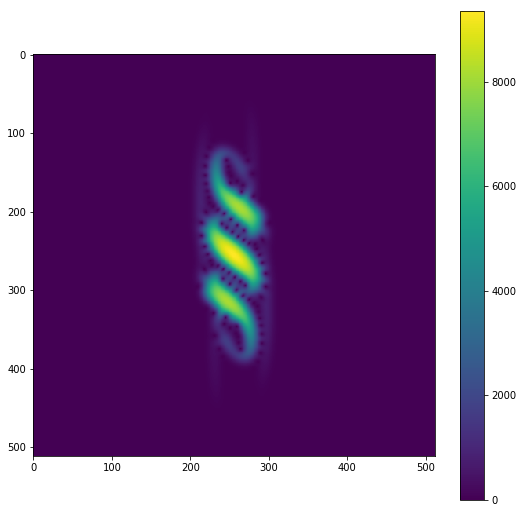

In [10]:
plt.figure(figsize=(9,9))
plt.imshow(np.abs(density))
plt.colorbar()

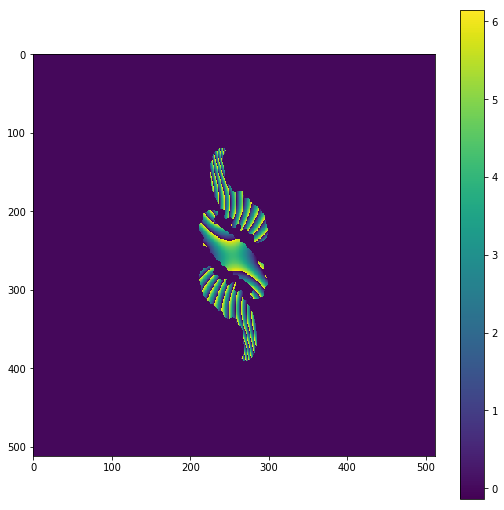

In [48]:
plt.figure(figsize=(9,9))
plt.imshow((3+np.angle(density))*(np.abs(density)>2e3))
plt.colorbar()

In [15]:
gpcore.Setup(DIM,g, 1e-3,  True, 0.001)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,200,4, True)

gpcore.Setup(DIM,g, 1e-1,  False, 0.001)
gpcore.SetHarmonicPotential(1,0.4) 
gpcore.Evolve(x,9,4, True)

gpcore.Setup(DIM,g, 1e-3,  False, 0.003)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,20000,50, True)

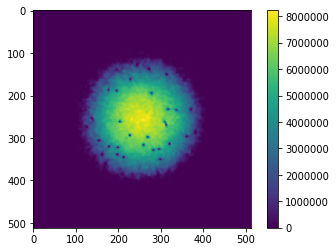

In [38]:
plt.imshow(np.abs(x)**2)
plt.colorbar()

plt.show()

In [39]:
xnew = x.copy()

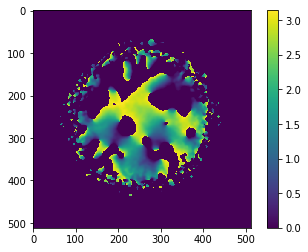

In [40]:
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

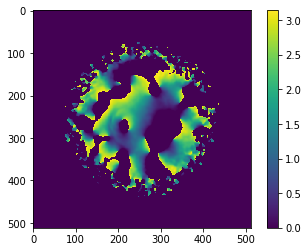

In [41]:
plt.imshow(np.angle(xold)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

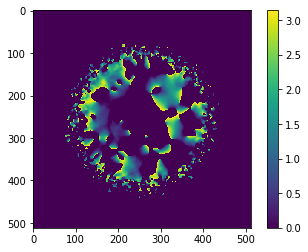

In [42]:
plt.imshow(np.angle(xold/xnew)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

In [7]:
dir(gpcore)

['Evolve',
 '__builtin__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_gpcore',
 '_newclass',
 '_object',
 '_swig_getattr',
 '_swig_property',
 '_swig_repr',
 '_swig_setattr',
 '_swig_setattr_nondynamic',
 'cvar',
 'getPotential',
 'setHarmonicPotential',
 'setup']

In [8]:
x = 500e-6
u = 1e-25 * (x**2)

In [10]:
u

2.4999999999999997e-36

# vortex lattice squeezing

In [710]:
omega = 4

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 1.5e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 1000 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        phi = 10*np.arctan2((i-DIM//2), (j-DIM//2))
        phase = np.exp(1.j * np.mod(phi,2*np.pi))
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        x[i,j] *= phase
        

gpcore.Setup(DIM, fov, g, 5e-3,  True, 0.001)
gpcore.SetHarmonicPotential(omega,0.2) #omega, epsilon

steps = 1000
Omega = 0.75*omega* np.ones(steps)
gpcore.RotatingFrame(Omega)

# gpcore.GetPotential(V)
# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,steps,40, True, 1e7)
xrelax=x.copy()

In [169]:

gpcore.Setup(DIM, fov, g, 1e-4,  False, 0.001)

gpcore.SetHarmonicPotential(omega,0.0) #omega, epsilon
gpcore.GetPotential(V)
steps = 20000
Omega = omega* np.ones(steps)
gpcore.SetHarmonicPotential(omega,0.2) #omega, epsilon
gpcore.RotatingFrame(Omega)
gpcore.AbsorbingBoundaryConditions(1,600e-6)

# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,steps,40, True, 1e7)

# Edge states

In [15]:

omega = 2*np.pi*10

hbar = 1.05e-34
omegaz = np.sqrt(8) * omega
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 5e5
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
lb = np.sqrt(hbar / (2*mass *omega))

fov = 300 * 1e-6

DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
noise = (0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 10
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        noise[i,j]= np.exp(0.2 * 1.j * 2*np.pi * (0.5-np.random.rand()))
        

gpcore.Setup(DIM, fov, g, 1e-5,  True, 0)
gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.Evolve(x,10000,100, True, 3e8)
xrelax = x.copy()

Text(0.5, 0, 't [s]')

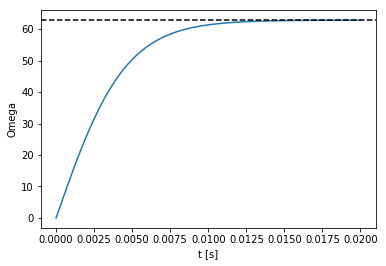

In [35]:
whirrMax = omega

steps = 4000
times = np.arange(steps)
whirrtime = 3000

# Omega = whirrMax* np.ones(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]

# Omega = [np.min([whirrMax, omega * 1.02 * np.tanh(2.4 * t / whirrtime)]) for t in times]

plt.plot(5e-6*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.ylabel('Omega')
plt.xlabel('t [s]')
# plt.savefig('figures/rotini1d/rampup.png')

In [36]:
x = xrelax.copy()
gpcore.Setup(DIM, fov, g, 2e-5, False, 0.00)

gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.SetEdgePotential(10,150e-6,15e-6)
gpcore.RotatingFrame(Omega)
# gpcore.AbsorbingBoundaryConditions(1,150e-6)
gpcore.SetupSpoon(1e5, 20e-6)

gpcore.Evolve(x, steps, 50, True, 3e8)

xwide = x.copy()

In [37]:
x = xwide.copy()
gpcore.Setup(DIM, fov, g, 2e-5, False, 0.00)

gpcore.SetHarmonicPotential(omega,0.4) #omega, epsilon
gpcore.SetEdgePotential(10,150e-6,15e-6)
gpcore.RotatingFrame([omega])
# gpcore.AbsorbingBoundaryConditions(1,150e-6)
gpcore.SetupSpoon(1e5, 20e-6)

gpcore.Evolve(x, 0, 50, True, 2e8)

xedge = x.copy()

# Datasets for superfluidGAN

In [195]:
omega = 2*np.pi

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 1.5e6
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 400 * 1e-6

DIM = 128
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))

def starterpsi(vortexnumber=0, width=10):
    x = (1+0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            phi =vortexnumber*np.arctan2((i-DIM//2), (j-DIM//2))
            phase = np.exp(1.j * np.mod(phi,2*np.pi))
            x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
            x[i,j] *= phase
    return x
        
x = starterpsi(vortexnumber=6)

gpcore.Setup(DIM, fov, g, 5e-3,  True, 0.001)
gpcore.SetHarmonicPotential(omega, 0.0) #omega, epsilon

steps = 500
Omega = 0.5*omega* np.ones(steps)
gpcore.RotatingFrame(Omega)

# gpcore.GetPotential(V)
# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,steps,100, True, 4e7)
xrelax=x.copy()

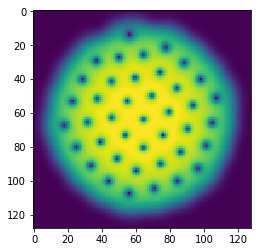

In [140]:
plt.imshow(np.abs(cloud).T)
plt.savefig('data/n.png')

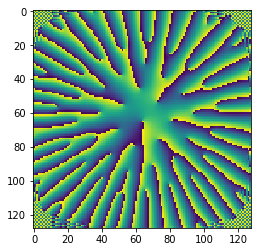

In [141]:
plt.imshow(np.angle(cloud))
plt.savefig('data/phi.png')

In [197]:
rg = np.array([np.real(xrelax), np.imag(xrelax),0*np.real(xrelax)])
rg=rg.T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


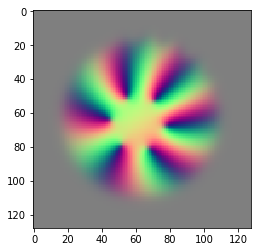

In [198]:
plt.imshow((rg+5000)/10e3)

In [213]:
datafile='data/vortexlattices.hdf5'
    
omegaRlist = [0.1,0.3,0.4,0.5,0.6,0.7,0.8]
vortexlist = [1,2,3,4,5,6,9,20]
stepslist = [500,1000,5000,20000]

allomegas = []
allvortexes = []
allsteps = []
allpsi = []

for o in tqdm(omegaRlist, leave=False):
    for v in tqdm(vortexlist, leave=False):
        for s in tqdm(stepslist, leave=False):
            x = starterpsi(vortexnumber=v)
            gpcore.Setup(DIM, fov, g, 5e-3,  True, 0)
            gpcore.SetHarmonicPotential(omega, 0.0) #omega, epsilon
            Omega = o*omega* np.ones(s)
            gpcore.RotatingFrame(Omega)
            gpcore.Evolve(x,s,100, True, 4e7)
            allpsi.append(x.copy())
            allomegas.append(o)
            allvortexes.append(v)
            allsteps.append(s)

with h5py.File(datafile, 'a') as f:
    dsname = f"vlattice"
    dset = f.create_dataset(dsname, data=np.array(allpsi))
    dset.attrs['o'] = allomegas
    dset.attrs['v'] = allvortexes
    dset.attrs['s'] = allsteps
        


In [214]:
len(allpsi)

224

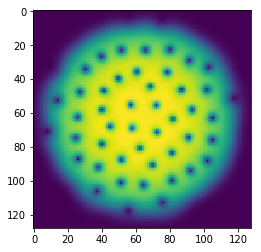

In [232]:
plt.imshow(np.abs(allpsi[220]))

## make facades dataset

In [136]:

with h5py.File('data/vortexlattices.hdf5', 'r') as f:
    dset=f["vlattice"]
    for i in tqdm(range(len(dset)), leave=False):
        cloud = dset[i]
        im = getimage(cloud)
        im.save('data/vlattices/'+str(i)+'.jpg')
        
            
        
        
    

In [46]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


In [135]:
def getimage(psi):
    n = np.abs(psi)**2
    nimg = [255*n/n.max(),255*n/n.max(),255*n/n.max()]
    rg = np.array([np.real(cloud), np.imag(cloud),0*np.real(cloud)])
    phiimg = 255*(rg+np.max(np.real(cloud)))/(2.4*np.max(np.real(cloud)))
    allimg = np.hstack([nimg,phiimg]).T
    return Image.fromarray(np.uint8(allimg))

In [110]:
im.save('data/vlattices/test.jpg')

In [128]:
im = getimage(cloud)

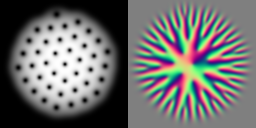

In [129]:
im

In [86]:
np.shape(im1.T)


(128, 128, 3)

In [87]:
im0 = Image.fromarray(np.uint8(np.squeeze([im[0]])).T)

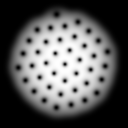

In [88]:
im0

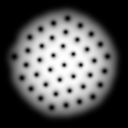

In [20]:
im

In [84]:
n = np.abs(cloud)**2
rg = np.array([np.real(cloud), np.imag(cloud),0*np.real(cloud)])
rg=rg.T

# phi = np.angle(cloud)
# plt.imshow(np.vstack([n,phi]))

In [10]:
from PIL import Image

In [17]:
im = Image.fromarray(np.uint8(255*(rg+5000)/10e3))

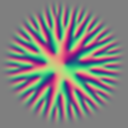

In [18]:
im

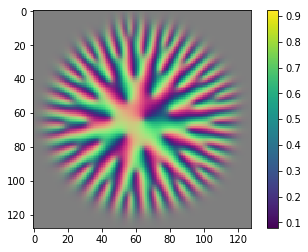

In [16]:
plt.imshow((rg+5000)/10e3)
plt.colorbar()

# 1d vortex lattices

to find modes, rotons, etc

In [749]:
omega = 4

hbar = 1.05e-34
omegaz = 10
mass = 3.8e-26
a0 = 5.3e-11
a_s = 100*a0
N = 1e4
g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))

Rxy = np.sqrt(15 * N * a_s * np.sqrt(mass * omegaz / hbar))
a_h = np.sqrt(hbar / (2*mass *omega))
lb = np.sqrt(hbar / (mass *omega))
fov = 7 * Rxy * a_h
fov = 1000 * 1e-6

DIM = 512
V = np.zeros((DIM,DIM))
        
def starterpsi(vortexnumber=0, width=100, epsilon=0, sep=10):
    x = (1+0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            phi=0
            for k in range(vortexnumber):
                pos = DIM//2 + (-vortexnumber//2  + k)*sep
                phi += np.arctan2((i-pos), (j-DIM//2))
#             phi = 2*np.arctan2((i-DIM//2), (j-DIM//2))
            phase = np.exp(1.j * np.mod(phi,2*np.pi))
            x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/((1-epsilon)*width))** 2. ) + 1.j
            x[i,j] *= phase
    return x
        
epsilon = 0.4
x = starterpsi(vortexnumber=5, width=100, epsilon=epsilon)

gpcore.Setup(DIM, fov, g, 1e-3,  True, 0.001)
gpcore.SetHarmonicPotential(omega, epsilon) #omega, epsilon

steps = 100
Omega = 0.75*omega* np.ones(steps)
gpcore.RotatingFrame(Omega)

# gpcore.GetPotential(V)
# plt.contour(V)
# plt.gca().set_aspect('equal', 'box')
# plt.show()

gpcore.Evolve(x,steps,40, True, 1e8)
xrelax=x.copy()

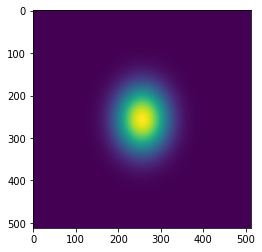

In [729]:
plt.imshow(np.abs(x))

# colormap interpolation

In [6]:
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit

def quad(x,a,b,c,d): return d + c*x + b * (x**2) + a * (x**3)

In [7]:
rgb = cm.get_cmap('inferno')
x = np.linspace(0,1,100)
colors = np.array([rgb(xx) for xx in x])

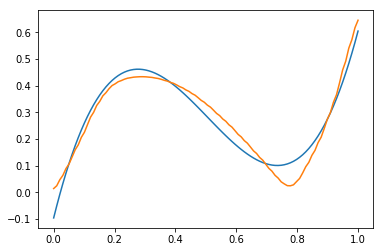

[  7.5327364  -11.43486921   4.60270604  -0.09628023]


In [8]:
channel = 2
f, _  = curve_fit(quad, x, colors[:,channel], [1,1,1,1])
plt.plot(x, quad(x, *f))
plt.plot(x,colors[:,channel])
plt.show()
print(f)

# HDF5

In [35]:
import numpy as np
import h5py


In [36]:
arr = np.random.rand(100,10)

In [37]:
with h5py.File('data/random.hdf5', 'a') as f:
    dset= f.create_dataset("default", data=arr)
    dset.attrs['test'] = arr

In [27]:
with h5py.File('data/random.hdf5', 'a') as f:
    dset= f.create_dataset("default1", data=arr)
    dset.attrs['test'] = 1

In [39]:
with h5py.File("data/random.hdf5", "r") as f:
    data = f['default']
    print(data.attrs['test'][0])
    for key in f.keys():
        print(key)


[0.07073221 0.18006849 0.13877419 0.1811971  0.369533   0.32693269
 0.63765565 0.4217243  0.14765824 0.19217319]
default


In [33]:
with h5py.File("data/random.hdf5", "r") as f:
    data = f['default'][:,1]
    

In [34]:
data

array([0.7858933 , 0.87965748, 0.24594595, 0.38021024, 0.82619913,
       0.88153466, 0.64669606, 0.51645997, 0.61786944, 0.71347704,
       0.47453663, 0.42676964, 0.21184069, 0.97928187, 0.01297011,
       0.02077212, 0.17948574, 0.32876222, 0.12427044, 0.67109227,
       0.06673292, 0.24024072, 0.90133762, 0.29846695, 0.07346949,
       0.24363151, 0.72225246, 0.29026921, 0.19453676, 0.57569686,
       0.83396573, 0.69887963, 0.81429063, 0.80430952, 0.30969732,
       0.68868483, 0.18677031, 0.95117993, 0.70666246, 0.11633369,
       0.63871595, 0.55575362, 0.65986085, 0.5106908 , 0.84684314,
       0.30382152, 0.31996382, 0.78585858, 0.89902282, 0.14420026,
       0.5669585 , 0.37885028, 0.7658143 , 0.85117303, 0.61741277,
       0.76761723, 0.09410375, 0.58322832, 0.68094037, 0.98383185,
       0.18736508, 0.6030691 , 0.44172423, 0.33012646, 0.27532812,
       0.37507284, 0.49574024, 0.16626893, 0.21068883, 0.4051676 ,
       0.10640467, 0.5041243 , 0.93979565, 0.59448023, 0.32786

In [11]:
f.close()